# Hands on session: Analysis of Higgs data

In [1]:
%reload_ext custom_magics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from custom_functions import *

In [3]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-acossard>

## Prepare the input data

In [4]:
#read input dataset from parquet

inputFile = 'hdfs://192.168.2.39/data/Higgs10M.parquet' 
#inputFile = 'hdfs://192.168.2.39/data/Higgs100k.parquet' 
#other files are: Higgs1M.parquet, Higgs100k.parquet

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

CPU times: user 2.66 ms, sys: 4.46 ms, total: 7.11 ms
Wall time: 5.38 s


In [5]:
total_events = df.count()

print('There are '+str(total_events)+' events')

There are 9560096 events


#### QUESTION 1: is the dataset unbalanced? Do we need undersampling?

In [6]:
# motivate your answer here
# see the answer in the cells below

In [6]:
#I did this only to see the df in the pandas way which I am more used to
panda = df.limit(10).toPandas()

In [7]:
panda

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pt,jet1_eta,jet1_phi,jet1_b-tag,...,je4_eta,jet4_phi,jet4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,1.194134,0.169416,0.840477,0.635367,-0.774299,0.591966,1.180329,-0.611975,0.000000,...,1.761793,-1.561790,0.000000,0.798830,0.712128,1.198602,0.759438,0.684867,0.825651,0.755802
1,1.0,1.283992,0.731396,1.005270,1.207458,0.694363,1.195108,0.295063,-0.517728,2.173076,...,-0.130381,-0.917536,0.000000,0.314012,0.639129,0.975548,0.817030,0.955889,0.979370,0.790856
2,0.0,0.571171,-0.409121,-1.071681,0.681941,-0.650838,1.416889,1.417984,-0.894152,0.000000,...,0.323508,1.470911,0.000000,0.977863,0.921440,0.985130,0.958565,1.107009,0.982282,0.865807
3,1.0,0.794076,-0.558138,0.916493,1.304152,-0.624031,1.316029,-1.145721,1.421579,0.000000,...,-0.113725,0.404369,0.000000,1.032961,0.941942,1.386236,1.301317,0.858163,0.956550,0.868230
4,0.0,0.486072,-0.537685,1.656677,1.045107,-0.005942,0.787914,-0.427805,-1.144730,2.173076,...,-1.293002,-1.673882,0.000000,0.502346,0.908607,0.987460,0.814304,1.305329,0.781702,0.689935
5,0.0,2.013466,0.025269,0.024830,0.794762,0.437074,1.346901,0.171284,-1.480681,2.173076,...,-0.764160,1.179582,3.101961,0.965795,1.176070,0.979901,0.760852,0.947435,1.080995,0.907347
6,1.0,1.679840,0.981706,-0.833645,0.207592,1.047030,0.971586,0.456471,0.914880,2.173076,...,-1.584491,0.376624,0.000000,0.912182,0.849254,0.989618,1.192563,0.802145,0.867156,0.759357
7,1.0,0.891986,-1.199010,0.956997,1.361062,0.734834,0.476266,-1.648758,-1.610405,0.000000,...,-1.380449,-0.524656,0.000000,0.986707,0.822986,0.991255,0.969702,0.723257,1.158721,1.000757
8,1.0,0.945059,-0.509440,1.388125,0.749162,-0.870459,0.767302,-1.242764,-1.504519,2.173076,...,0.292693,-0.031339,3.101961,0.574387,1.095291,1.042732,0.596038,0.814329,0.680044,0.644025
9,1.0,0.541890,-2.069738,1.359272,0.447037,-0.079829,1.183199,-1.067493,0.657650,2.173076,...,-2.128324,-0.861490,0.000000,0.874763,0.640899,0.986907,0.792481,0.948588,0.942737,0.811832


In [8]:
df_0 = df.filter(df["label"]==0)

In [9]:
df_1 = df.filter(df["label"]==1)

In [10]:
print('#0 events '+str(df_0.count()), '\n#1 events ' + str((df_1.count())))

#0 events 4494163 
#1 events 5065933


The dataset it's quite balanced!

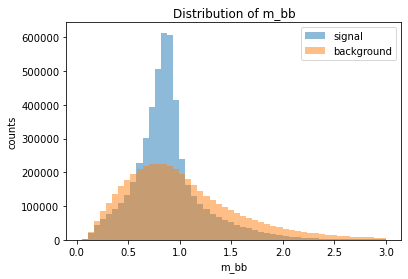

In [11]:
#plot invariant mass distribution 
plotSignalvsBg(df, 'm_bb')

#### QUESTION 2: Split the dataset into 5 parts with random events

In [12]:
shuffled = df.sample(False, fraction=0.1)
n = 5
rows = shuffled.count() // n
copy_df = shuffled
i = 0

while i < n:
    temp_df = copy_df.limit(rows)
    copy_df = copy_df.subtract(temp_df)
    i += 1

#### QUESTION 3: split the dataset for training and test

In [13]:
# split into two dataframes called training and test
train, test = df.randomSplit([0.8,0.2])

#### Create the input feature vector

Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html

In [15]:
feature = train.columns
feature.remove('label')

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature, outputCol='features')

train = assembler.transform(train)
test = assembler.transform(test)

## ML with pyspark

Try to solve the signal vs background classification problem using a new algorithm of your choice (obviously, not GBT or MCP)
Documentation at: https://spark.apache.org/docs/2.2.0/ml-classification-regression.html

In [17]:
from pyspark.ml.classification import *

Let's fit the model on the **training dataset**:

In [18]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(labelCol='label', featuresCol='features', maxIter=10, regParam=0.1)


lsvcModel = lsvc.fit(train)


print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

Coefficients: [-0.28476168904228566,0.0004476648598721379,0.0014383648913086377,-0.4451201758533301,-0.0005475824710381052,0.4502377311702288,-0.00019850525420064252,0.0008477783111735648,0.061856457713410286,0.09409855155050531,-0.0006070054894730885,-0.00043280164771593424,-0.06175201418525403,0.05985813101560631,-0.0008842584391938383,0.0005449470282169233,-0.051847301709235974,0.1178679743296776,-0.0009777643807202545,0.0010276465691705546,-0.024481829201789998,-0.003498532006534431,0.468439269671473,0.6089562758832174,0.3084840106859452,-0.8201540633102364,0.09897063819285568,-1.2415885132366107]
Intercept: 0.9659587252312927


#### QUESTION 4: Compute the accuracy on the test dataset

In [19]:
result = lsvcModel.transform(test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))


Test set AUC = 0.6585533635427844


In [20]:
printMetrics(evaluator, result)

AUC: 0.659
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0|916022|
|  0.0|       1.0|645236|
|  1.0|       0.0| 96619|
|  0.0|       0.0|253423|
+-----+----------+------+

n precision: 0.587
n recall: 0.905
n accuracy: 0.612
n F1 score: 0.712


#### QUESTION 5: Are we over/under-fitting the data? How could the accuracy be improved?

In [22]:
tot = 916022 + 645236 + 96619 + 253423

In [21]:
cf_mat = [[253423,96619],[645236,916022]]

In [23]:
cf_mat = [[(253423/tot)*100,(96619/tot)*100],[(645236/tot)*100,(916022/tot)*100]]

In [24]:
cf_mat

[[13.259195312091245, 5.055145712342385],
 [33.759012190655575, 47.926646784910794]]

In [25]:
#class 0
predicted_0 = (cf_mat[0][0] + cf_mat[0][1]) 
label_0 = (cf_mat[0][0] + cf_mat[1][0])
ratio_0 = predicted_0 / label_0

print(predicted_0,label_0,ratio_0)

18.31434102443363 47.01820750274682 0.38951593429765907


In [26]:
#class 1
label_1 = (cf_mat[0][1] + cf_mat[1][1]) 
predicted_1 = (cf_mat[1][0] + cf_mat[1][1])
ratio_1 = predicted_1 / label_1

print(predicted_1,label_1,ratio_1)

81.68565897556637 52.98179249725318 1.54176850433668


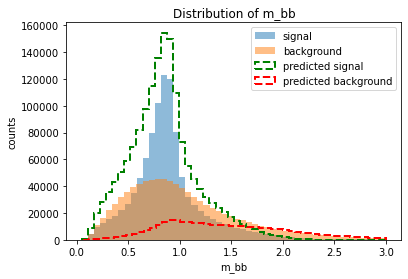

In [27]:
plotSignalvsBgWithPrediction(test, result, 'm_bb')

For the 0 class I have a 18% of prediction against the 47% of actual labels while for the class 1 I have a 81% of prediction against the 52% of the training set labels. I am underfitting and this is caused by false negative of the 0 class.

#### Hyperparameter tuning

We use the *spark_sklearn.grid_search* method.

In [28]:
subSample = train.sample(fraction=1.0/10, withReplacement=False).cache()
print('We will use',subSample.count(),' events for the grid search.')

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

We will use 764611  events for the grid search.


In [29]:
lsvc = LinearSVC(labelCol='label', featuresCol='features', maxIter=10, regParam=0.1)

In [30]:
#Do hyperparameter tuning 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lsvc = LinearSVC(labelCol='label', featuresCol='features', maxIter=10, regParam=0.1)

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

##### QUESTION 6: Compare n k-cross validator vs TrainValidation split methods 

In [31]:
paramGrid = ParamGridBuilder()\
  .addGrid(lsvc.maxIter, [0,2000])\
  .build()

In [32]:
#take care, might take long time, 
cv = CrossValidator(estimator=lsvc, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=10, parallelism=num_workers) 

In [33]:
%time bm = cv.fit(subSample)

CPU times: user 815 ms, sys: 341 ms, total: 1.16 s
Wall time: 1min 52s


In [34]:
bm.bestModel.getMaxIter()

2000

In [35]:
tvs = TrainValidationSplit(estimator=lsvc,
                           evaluator=evaluator,
                           estimatorParamMaps=paramGrid,
                           trainRatio=0.8)

In [36]:
%time bm_2 = tvs.fit(subSample)

CPU times: user 83.3 ms, sys: 32.5 ms, total: 116 ms
Wall time: 20 s


In [37]:
bm_2.bestModel.getMaxIter()

2000

CV and TVS gave me the same result. I did not want to run longtime calculation but maybe seraching in a wider range of the MaxIter parameters will give different numbers.

#### QUESTION 7: do you get a better accuracy? Why? Are you over/underfitting?

In [38]:
res_1 = bm.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(res_1)))

Test set AUC = 0.6590128341447168


In [39]:
printMetrics(evaluator, res_1)

AUC: 0.659
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0|920216|
|  0.0|       1.0|649929|
|  1.0|       0.0| 92425|
|  0.0|       0.0|248730|
+-----+----------+------+

n precision: 0.586
n recall: 0.909
n accuracy: 0.612
n F1 score: 0.713


In [40]:
res_2 = bm_2.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(res_2)))

Test set AUC = 0.659012147132099


In [41]:
printMetrics(evaluator, res_2)

AUC: 0.659
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0|920216|
|  0.0|       1.0|649929|
|  1.0|       0.0| 92425|
|  0.0|       0.0|248730|
+-----+----------+------+

n precision: 0.586
n recall: 0.909
n accuracy: 0.612
n F1 score: 0.713


The model improved a bit but not so much.  If we compare the metrics with the one of the not tuned model, the values are quite similar so we are always underfiting the data. In general, I would say that lsvm is not a good model in this case.

#### QUESTION 8

pick any two models (can be any from pyspark MLLib, Keras Sequential, BigDL sequential) and:
- compare them in terms of performances (you can use results from previous days)
- compare how they scale in terms of performances and training time when you change the number of executors (for example, from 1 to 5)
- discuss the results

I will compare my model with GBT since I think it is the more similar to LSVM. Let's begin from my model. I've run the LSVM on the data the first time getting an accuracy of 0.611 while using CV the accuracy rises to 0.612, not a great improve. This is confirmed by the fact that also the values of precision, recall and F1 are not changing. This could depends on two factors: the first one is that the model which I've chosen is not suitable to my training set or the fact that the only parameter that I gridsearched was the maximum number of iteration. In particular on this case, I would say both. Comparing LSVM with data form previous exercises, in particular from GBT, it is clear that the trees algotirhm performs better. I searched for the metrics using the GBT and I got accuracy of 0.705, precision of 0.719, reacall of 0.730 and finally F1 of 0.724. To confirm the analysis, I ran the same calculation on MCP and I got accuracy of 0.671, precision of 0.666, recall of 0.760 and finally an F1 score of 0.710. This confirms that, among the three models I picked, the best one is GBT.

In [ ]:
#scaling time

To see thee computational time, I ran the script on another Jupyter notebook using the 1M event file

In [42]:
import matplotlib.pyplot as plt

In [43]:
n_workers = [1,2,3,5,10,15,20,50]
total_time =[46.4,31.1,19.8,41.5,38.3,21,19.6,21.2] 

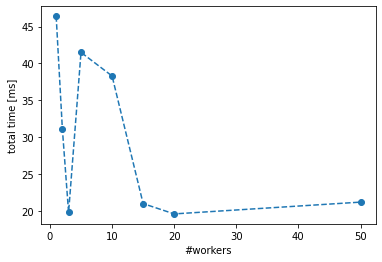

In [44]:
plt.plot(n_workers,total_time,'o--')
plt.xlabel('#workers')
plt.ylabel('total time [ms]')
plt.show()

Except for the point 2 and 3, the scaling is quite coherent to what I was expecting

In [45]:
# When you're done, stop spark
spark.stop()